# Unsupervised methods for Anomaly detection

In this part of the project, we will learn methods for determining anomalies in data (anomaly detection) and techniques for testing whether new data comes from a known distribution (novelty/out-of-distribution (OOD) detection).

Anomaly detection can be implemented using:
*   clustering methods
*   density/neighborhood methods


## Task

The task is to explore various methods of anomaly detection - illustrated in this manual (notebook) for detecting anomalies in real data sets.

Course of the task:


**1. We select 3 datasets** - see below for suggested repositories. We choose sets with different characteristics (dimensionality, number of outliers).

**2. For each set** we test the effectiveness of anomaly detection using 3 methods - e.g. given in this manual, other methods can also be used (e.g. kNN, see **PyOD** or **PyODDS** libraries). We try to tune the parameters of the anomaly detector so as to get high efficiency of the method.

**3. We prepare a test report** - it should include measures of the effectiveness of each method tested (ROC, AUC, FPR, TPR) and the impact of the parameters we tuned.


Suggested repositories from which we can download data for testing:

https://archive.ics.uci.edu/

https://web.archive.org/web/20240421011255/https://odds.cs.stonybrook.edu/

https://www.kaggle.com/datasets

https://www.kaggle.com/datasets?search=imbalanced&fileType=csv

https://paperswithcode.com

https://paperswithcode.com/datasets?q=anomaly+detection&v=lst&o=match&mod=tabular&page=1

https://github.com/GuansongPang/ADRepository-Anomaly-detection-datasets/tree/main

https://www.unb.ca/cic/datasets/



---



## Clustering methods in the task of anomaly detection

Unsupervised learning for anomaly detection is based on one of the assumptions:

- normal observations form clusters, anomalies - do not belong to a cluster  
- normal observations form numerous/large clusters, anomalies - small clusters
- normal observations lie close to the centroid of the cluster, anomalies - far from the centroid of the nearest cluster

We will show this with the example of anomaly detection - spam in email lists.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os

In [ ]:
datadir = '/content/drive/MyDrive/Data'
fn = 'spam.dat'

In [ ]:
#dataframe = pd.read_csv("./data/spam.dat")
df = pd.read_csv(os.path.join(datadir, fn))
df.head(5)

,ACT_NOW,ADDRESSES_ON_CD,ADULT_SITE,ADVERT_CODE,ADVERT_CODE2,ALL_CAPS_HEADER,ALL_CAP_PORN,ALL_NATURAL,AMATEUR_PORN,AMAZING,...,X_ENC_PRESENT,X_LIBRARY,X_LIST_UNSUBSCRIBE,X_MSMAIL_PRIORITY_HIGH,X_PRECEDENCE_REF,X_PRIORITY_HIGH,X_STORMPOST_TO,X_X_PRESENT,YOUR_INCOME,target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,yes
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,no
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,yes
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,no
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,yes


In [ ]:
labels = df["target"]
df.drop("target", inplace=True, axis=1)
df.describe()
print(df.shape)

(4789, 462)


In [ ]:
labels.value_counts()

,count
target,
no,2949
yes,1840


In [ ]:
labels = [1 if l == "yes" else 0 for l in labels]

### Kmeans Algorithm

Let's start with the classic k-means algorithm (discussed in lecture). In this case, we set the target number of clusters (many algorithms require this) to 2 - by default, anomalous and normal samples.

The method will try to set two centroids (points in space), so as to best divide the space. Samples that are closest to a given centroid will be assigned to it (clusters/groups will be formed).


In [ ]:
from sklearn.cluster import KMeans

predicted = KMeans(n_clusters=2, random_state=33).fit_predict(df)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(labels, predicted))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      2949
           1       1.00      0.75      0.86      1840

    accuracy                           0.90      4789
   macro avg       0.93      0.87      0.89      4789
weighted avg       0.92      0.90      0.90      4789



In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(labels, predicted)

array([[2944,    5],
       [ 459, 1381]])

Note - the KMeans algorithm is non-deterministic -- the result depends on the initial centroids (e.g., it may change after changing random_state).

### Hierarchical clustering algorithm

Another method of clustering is hierarchical clustering. Samples are combined into pairs and then into groups (or subdivided - you can do that too) based on their distance from each other.

In [ ]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering()      # with default n_clusters=2
clustering = model.fit_predict(df)
print(classification_report(labels, clustering))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      2949
           1       0.86      0.86      0.86      1840

    accuracy                           0.89      4789
   macro avg       0.88      0.88      0.88      4789
weighted avg       0.89      0.89      0.89      4789



In [ ]:
print(clustering)

[0 0 1 ... 1 0 1]


Visualization of the result of hierarchical grouping -- dendrogram

From the analysis of the dendrogram, you can arrive at how many groups we should establish -- this can be done by analyzing the height of the bars.

In the example, the bottom of the dendrogram is cut off - we show the merging of groups of samples (at the very bottom would be the leaves - the samples themselves)

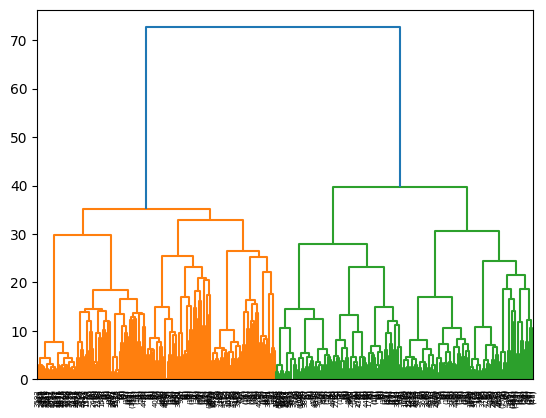

In [ ]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
import numpy as np


def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model.fit(df)
plot_dendrogram(model, truncate_mode="level", p=8) # p to liczba poziomów w dendrogramie

### DBSCAN

DBSCAN does not require the number of clusters -- it will be determined based mostly on the number of neighbors and the maximum distance between them.

Nice visualization: https://www.youtube.com/watch?v=h53WMIImUuc

In [ ]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=3, min_samples=7).fit_predict(df)
#print(classification_report(labels, clustering))

In [ ]:
print(np.array(np.unique(clustering, return_counts=True)).T)

[[  -1  537]
 [   0 4203]
 [   1   14]
 [   2    9]
 [   3    7]
 [   4    9]
 [   5   10]]


### Projection into a lower dimension

Finally, it is worth mentioning methods for projecting into a lower dimension -- this allows (coarse) visualization of multidimensional data. One method of dimensional projection is t-SNE, another -- PCA.

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, init='pca', learning_rate='auto')
projections = tsne.fit_transform(df)

import plotly.express as px


fig = px.scatter(
    projections, x=0, y=1,
    color=labels, labels={'color': 'spam'}
)
fig.show()




---



## Density methods - with the example of LOF

We will explain the task on the basis of the SMTP dataset - containing SMTP anomalies (attacks).


### SMTP dataset

http://odds.cs.stonybrook.edu/smtp-kddcup99-dataset/

SMTP (KDDCUP99)	\
points:      95156	\
dimenstions: 3	\
outliers:     30 (0.03%)

The dataset contains selected (aggregated) features of TCP connections, of which 30 (labeled as outliers) are attack attempts, the rest - normal traffic (inliers).

The task is to test the effectiveness of various anomaly detection methods for detecting these attacks.    


In [ ]:
!pip install h5py

In [ ]:
import numpy as np
import h5py

datadir = '/content/drive/MyDrive/Data'
fn = 'smtp.mat'
f = h5py.File(os.path.join(datadir, fn),'r')
#f = h5py.File('./data/smtp.mat','r')
print(f.keys())


<KeysViewHDF5 ['X', 'y']>


In [ ]:
import numpy as np
import h5py
f = h5py.File('./data/smtp.mat','r')
print(f.keys())


<KeysViewHDF5 ['X', 'y']>


In [ ]:
X = np.array(f.get('X')).T
y = np.array(f.get('y')).ravel().astype(int)

In [ ]:
# X zawiera obserwacje (wiersze) - cechy połączeń
# y - ocznaczenie połączeń jako ruch normalny (inlier) lub atak (outlier)
print(X)
print(X.shape)
print(y)
print(y.shape)  # 0 - inlier, 1 - outlier


[[ 0.09531018  7.09597607  5.79636166]
 [ 0.09531018  7.42601321  5.80844275]
 [-2.30258509  6.88663378  5.79939564]
 ...
 [-2.30258509  6.73471056  5.79939564]
 [ 0.09531018  6.91879413  5.80844275]
 [ 0.09531018  6.60272357  5.80242044]]
(95156, 3)
[0 0 0 ... 0 0 0]
(95156,)


### LOF

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

model = LocalOutlierFactor(n_neighbors=35, novelty=False, contamination='auto')
# model = LocalOutlierFactor(n_neighbors=35, novelty=False, contamination=0.001)

y_pred = model.fit_predict(X)  # 1 - inlier, -1 - outlier

In [ ]:
y_pred[y_pred==1] = 0    # inliers
y_pred[y_pred==-1] = 1   # outliers

In [ ]:
print(np.array(np.unique(y, return_counts=True)))

print(np.array(np.unique(y_pred, return_counts=True)))

[[    0     1]
 [95126    30]]
[[    0     1]
 [92539  2617]]


In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y, y_pred)

array([[92530,  2596],
       [    9,    21]])

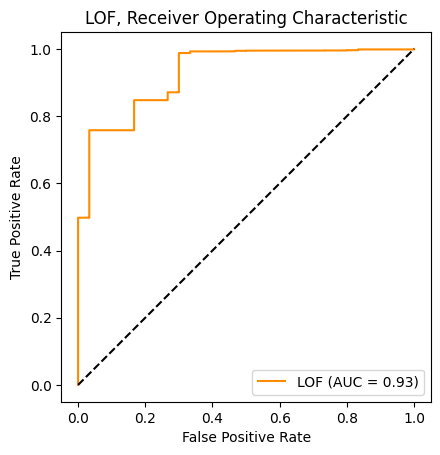

In [ ]:
### plot ROC curve

import math
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

model.fit(X)
y_pred = model.negative_outlier_factor_


RocCurveDisplay.from_predictions(
    y,
    y_pred,
    name="LOF",
    color="darkorange",
    pos_label=0
)
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LOF, Receiver Operating Characteristic")
plt.legend()
plt.show()
